## Weather Data : Visualization After Smoothing

### For New York State

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

_figsize=(10,7)

## Read Data

### Read Raw data for state

In [3]:
!rm -r ../Data/Weather/NY.*
!ls ../Data/Weather

decon_NY_SNWD.parquet  STAT_NY.pickle		 Weather_stations.tgz
recon_NY_SNWD.parquet  US_stations.tsv
stations.parquet       Weather_Stations.parquet


In [4]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  1291k      0  0:00:50  0:00:50 --:--:--  779k
-rw-r--r-- 1 jovyan users 64M May 13 00:34 ../Data/Weather/NY.tgz


In [5]:
!ls -l $data_dir

total 115964
drwxr-xr-x 10 jovyan users      340 May 13 00:08 decon_NY_SNWD.parquet
-rw-r--r--  1 jovyan users 66288146 May 13 00:34 NY.tgz
drwxr-xr-x 10 jovyan users      340 May 13 00:08 recon_NY_SNWD.parquet
drwxr-xr-x 10 jovyan users      340 Apr 10 21:22 stations.parquet
-rw-r--r--  1 jovyan users 51365103 May 13 00:30 STAT_NY.pickle
-rw-r--r--  1 jovyan users   731305 May 13 00:08 US_stations.tsv
drwxr-xr-x  7 jovyan users      238 May 13 00:08 Weather_Stations.parquet
-rw-r--r--  1 jovyan users   353056 May 13 00:30 Weather_stations.tgz


In [6]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du -h ./$parquet
%cd $cur_dir

/home/jovyan/work/Sections/Data/Weather
76M	./NY.parquet
/home/jovyan/work/Sections/Section2-Weather-PCA


In [7]:
!du -h $data_dir/$parquet

76M	../Data/Weather/NY.parquet


In [8]:
print(parquet)
weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
#weather_df=weather_df.drop('State') # we drop State because it already exists in "Stations".
print('number of rows=',weather_df.count())

NY.parquet
number of rows= 168398


In [9]:
weather_df.show(1)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 1 row



### read statistics information for state.

In [10]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  6646k      0  0:00:04  0:00:04 --:--:-- 6648k


In [11]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath

../Data/Weather/STAT_NY.pickle.gz
-rw-r--r-- 1 jovyan users 31373293 May 13 00:35 ../Data/Weather/STAT_NY.pickle.gz


In [13]:
print(gzpath)
!gunzip -f $gzpath
!ls -l $data_dir

../Data/Weather/STAT_NY.pickle.gz
total 115964
drwxr-xr-x 10 jovyan users      340 May 13 00:08 decon_NY_SNWD.parquet
drwxr-xr-x 31 jovyan users     1054 Apr 19 01:12 NY.parquet
-rw-r--r--  1 jovyan users 66288146 May 13 00:34 NY.tgz
drwxr-xr-x 10 jovyan users      340 May 13 00:08 recon_NY_SNWD.parquet
drwxr-xr-x 10 jovyan users      340 Apr 10 21:22 stations.parquet
-rw-r--r--  1 jovyan users 51365103 May 13 00:35 STAT_NY.pickle
-rw-r--r--  1 jovyan users   731305 May 13 00:08 US_stations.tsv
drwxr-xr-x  7 jovyan users      238 May 13 00:08 Weather_Stations.parquet
-rw-r--r--  1 jovyan users   353056 May 13 00:30 Weather_stations.tgz


In [14]:
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))


In [15]:
Measurements = STAT.keys()
Measurements

dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])

In [16]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

### Read information about US weather stations.

In [17]:
filename='Weather_Stations.tgz'
parquet='stations.parquet'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/Weather_Stations.tgz > ../Data/Weather/Weather_Stations.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k  100  344k    0     0   447k      0 --:--:-- --:--:-- --:--:--  447k


In [18]:
%cd $data_dir
!tar -xzf $filename
!du -s *.parquet
%cd $cur_dir

/home/jovyan/work/Sections/Data/Weather
77824	NY.parquet
1612	Weather_Stations.parquet
1888	decon_NY_SNWD.parquet
1888	recon_NY_SNWD.parquet
420	stations.parquet
/home/jovyan/work/Sections/Section2-Weather-PCA


In [19]:
stations_df =sqlContext.read.parquet(data_dir+'/'+parquet)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [20]:
weather_df.join?

In [21]:
jdf=weather_df.drop('name').join(stations_df,on='Station',how='left')
jdf.show(3)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 

In [22]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+--------------------+-----+
|                Name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [23]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|   TMIN_s20|  120|
|       TMIN|  120|
|   SNOW_s20|  121|
|       TOBS|  113|
|   SNWD_s20|  109|
|   TOBS_s20|  113|
|   PRCP_s20|  121|
|       TMAX|  120|
|       SNOW|  121|
|   TMAX_s20|  120|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [24]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1950|   12|
|1951|   12|
|1958|   12|
|1919|   12|
|1936|   12|
+----+-----+
only showing top 5 rows



In [25]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year )
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,dist_coast,latitude,longitude,elevation,state,Dist_coast,Latitude,Longitude,Elevation,State,Name
Measurement,,,,,,,,,,,,,,
SNOW_s20,USC00302610,2007,"[102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD_s20,USC00302610,2007,"[170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS_s20,USC00302610,2007,"[85, 203, 22, 204, 135, 204, 255, 204, 123, 20...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP_s20,USC00302610,2007,"[25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX_s20,USC00302610,2007,"[79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN_s20,USC00302610,2007,"[85, 209, 139, 209, 195, 209, 253, 209, 59, 21...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA


## Plots

In [26]:
raw_measurements=[m for m in Measurements if not '_s20' in m]
raw_measurements

['TOBS', 'PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']

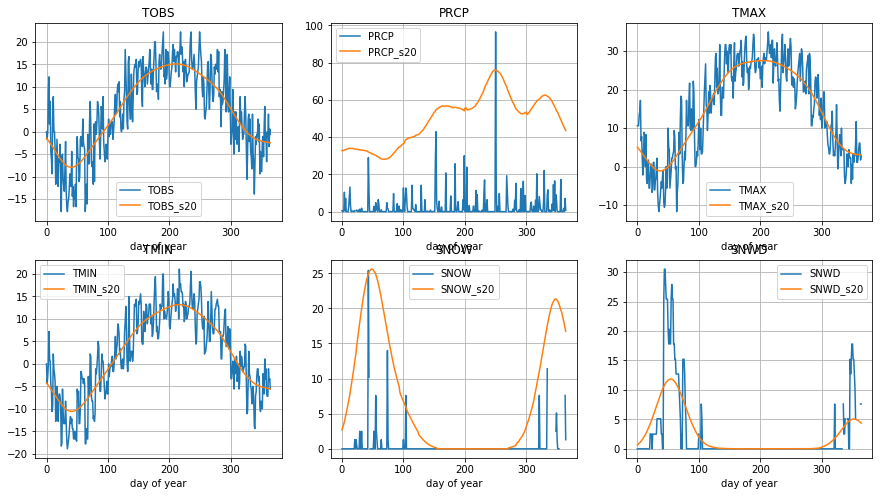

In [27]:
figure(figsize=[15,8])
i=1
for m in raw_measurements:
    subplot(2,3,i)
    i+=1
    if m=='PRCP' or m=='SNOW':
        f=20
    else:
        f=1
    plot(unpackArray(pandas_df.loc[m,'Values'],np.float16)/10.,label=m);
    ms=m+"_s20"
    
    plot(f*unpackArray(pandas_df.loc[ms,'Values'],np.float16)/10.,label=ms);
    xlabel('day of year')
    title(m)
    legend()
    grid()

In [28]:
from lib.YearPlotter import *
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

### Plots of mean and std of observations

In [29]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



In [30]:
from lib.MultiPlot import *

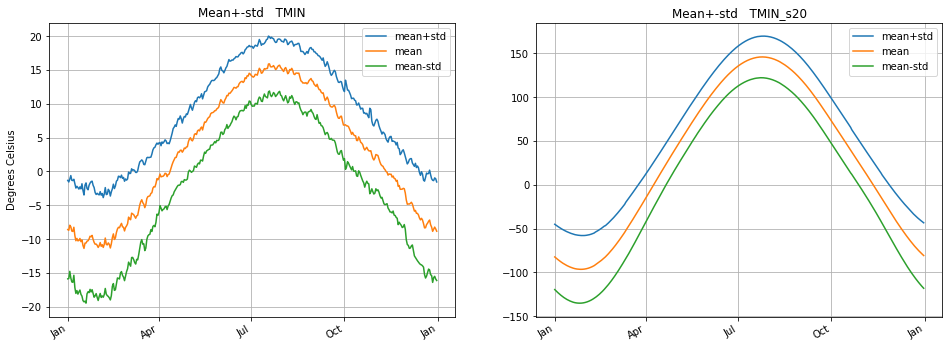

In [31]:
plot_pair(['TMIN','TMIN_s20'],plot_mean_std)

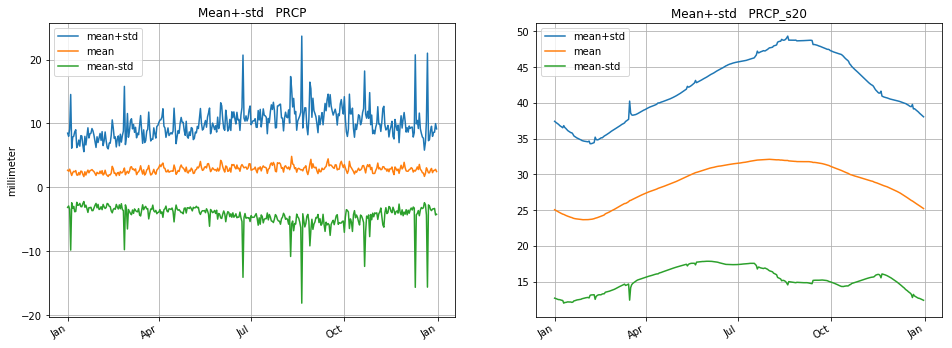

In [32]:
plot_pair(['PRCP','PRCP_s20'],plot_mean_std)

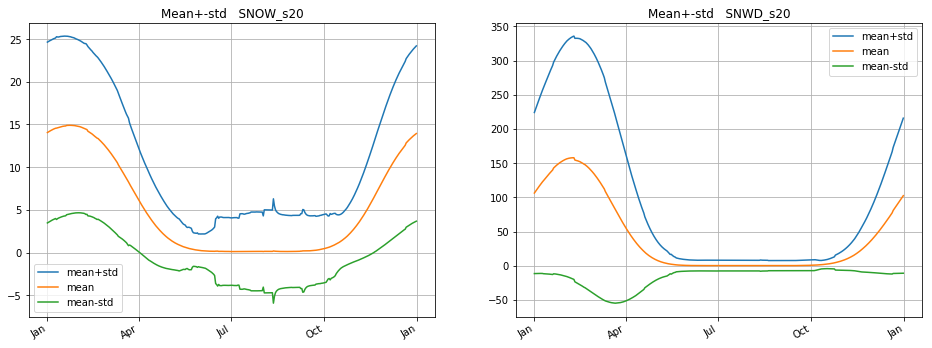

In [33]:
plot_pair(['SNOW_s20', 'SNWD_s20'],plot_mean_std)

### Plotting percentage of variance explained by Eigen-vectors

In [34]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

In [35]:
# create a subdirectory in which to place the plots.
!mkdir r_figures

mkdir: cannot create directory ‘r_figures’: File exists


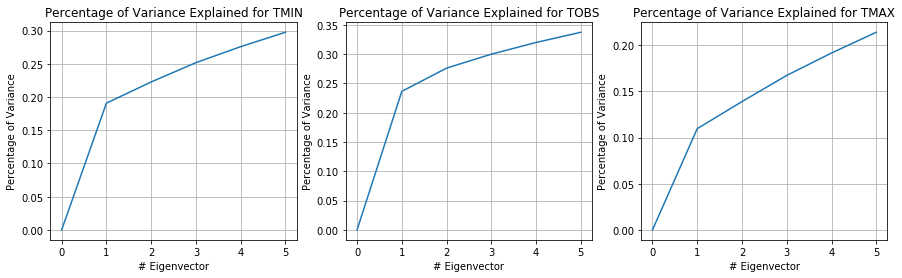

In [36]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

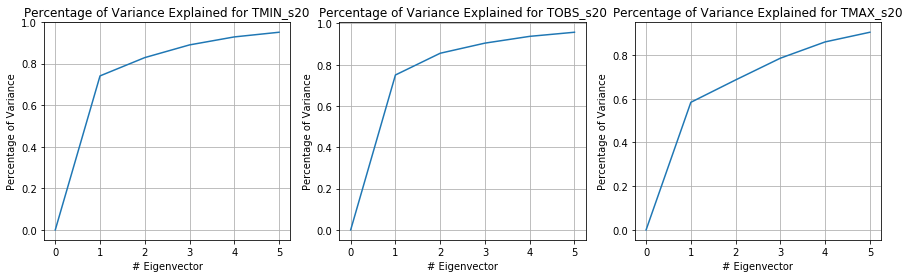

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN_s20', 'TOBS_s20', 'TMAX_s20']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

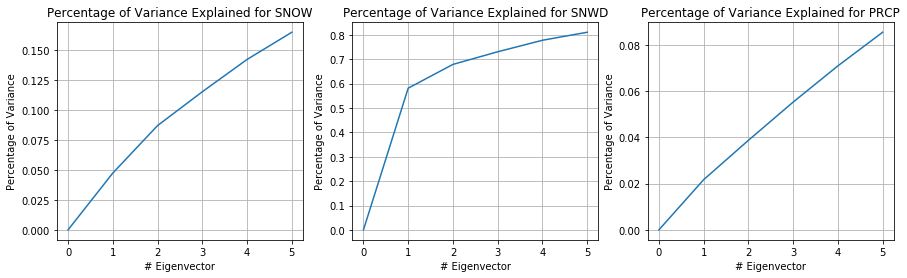

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

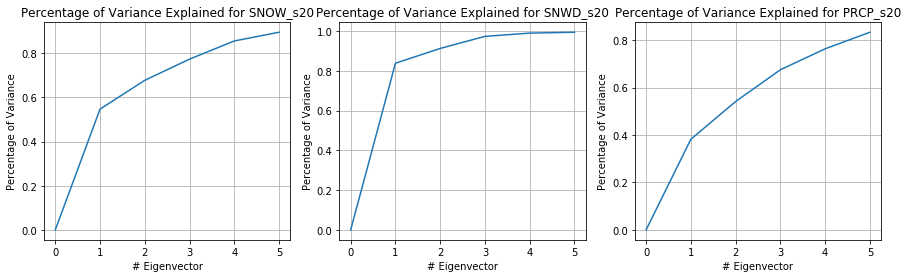

In [39]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW_s20', 'SNWD_s20', 'PRCP_s20']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png') 

### plotting top 3 eigenvectors

In [40]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

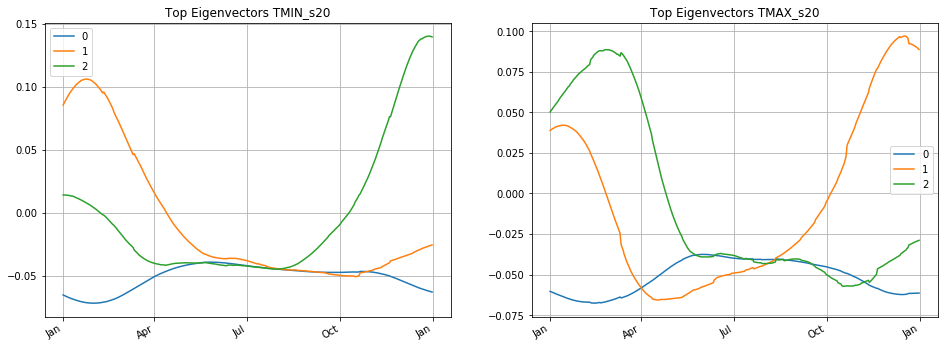

In [41]:
plot_pair(['TMIN_s20','TMAX_s20'],plot_eigen)

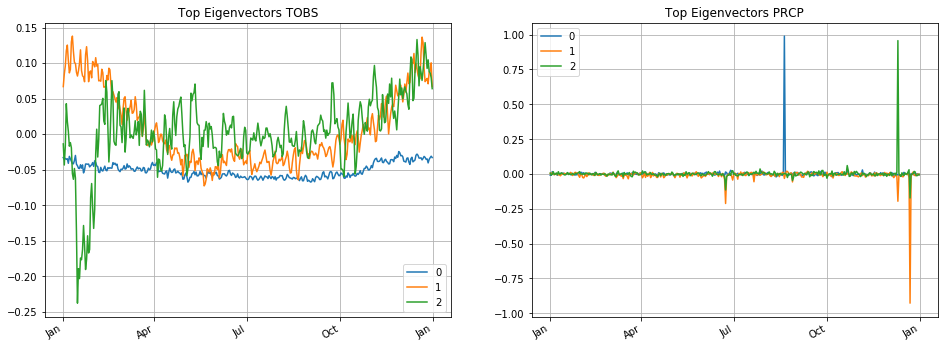

In [42]:
plot_pair(['TOBS','PRCP'],plot_eigen)

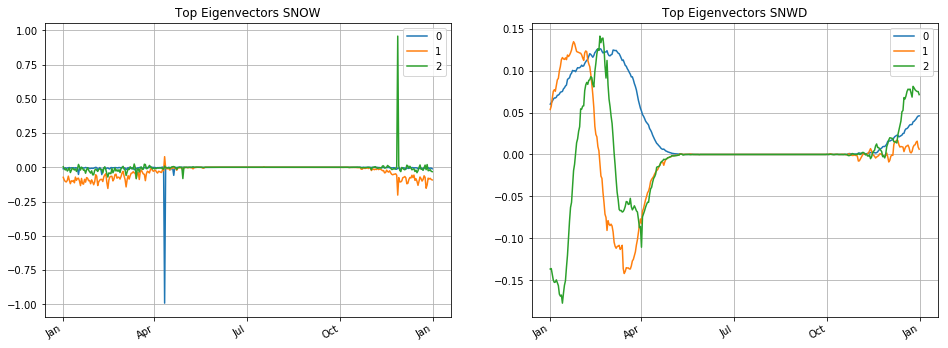

In [43]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

## Summary
We saw how to plot:
* Data from several (Station,Year,Measurement)
* The mean+-std for a particular (Station,Measurement)
* The percentage of cariance explained by top eigen-vectors.
* The top eigen-vectors